**Bibliotheken**

In [1]:
import os
import numpy as np
import subprocess
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
import cupy as cp
import torch
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import random

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


**GPU** 

In [2]:
torch.cuda.empty_cache()
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Pfad zu den Embeddings**

In [3]:
# Lade die Dateien
beta_all_epi = np.load('../../data/embeddings/beta/allele/Epitope_beta_embeddings.npz')
beta_all_trb = np.load('../../data/embeddings/beta/allele/TRB_beta_embeddings.npz')


***CHECK VOR DIMENSION REDUCTION***

Keys, Shape, Dimension von Embeddings

In [10]:
# Erhalte die Keys als Liste
epi_keys = list(beta_all_epi.keys())
trb_keys = list(beta_all_trb.keys())

# Drucke die ersten 5 und letzten 5 Keys
print(f"Anzahl der Keys in Epitope_beta_embeddings: {len(epi_keys)}")
print(f"Erste 5 Keys: {epi_keys[:5]}")
print(f"Letzte 5 Keys: {epi_keys[-5:]}")

print(f"\nAnzahl der Keys in TRB_beta_embeddings: {len(trb_keys)}")
print(f"Erste 5 Keys: {trb_keys[:5]}")
print(f"Letzte 5 Keys: {trb_keys[-5:]}")

# Prüfe die Form der ersten & letzten 5 Keys für beide Embeddings
print("\n Shapes der ersten 5 Epitope Keys:")
for key in epi_keys[:5]:
    print(f"  {key}: {beta_all_epi[key].shape}")

print("\n Shapes der letzten 5 Epitope Keys:")
for key in epi_keys[-5:]:
    print(f"  {key}: {beta_all_epi[key].shape}")

print("\n Shapes der ersten 5 TRB Keys:")
for key in trb_keys[:5]:
    print(f"  {key}: {beta_all_trb[key].shape}")

print("\n Shapes der letzten 5 TRB Keys:")
for key in trb_keys[-5:]:
    print(f"  {key}: {beta_all_trb[key].shape}")


Anzahl der Keys in Epitope_beta_embeddings: 1896
Erste 5 Keys: ['KLVVLGINAV', 'GPGHKARVL', 'FRYMNSQGL', 'NMLSTVLGV', 'DSFKEELDKY']
Letzte 5 Keys: ['ISQWLTNIF', 'SILDAVQRV', 'RLMKHYPGI', 'YLKLTDNVYIK', 'VSALSRAAEK']

Anzahl der Keys in TRB_beta_embeddings: 208722
Erste 5 Keys: ['CASSQDNNEQFF', 'CASSVISRVGETQYF', 'CASNPTDGGETQYF', 'CASSGSYAPGADTQYF', 'CASSYPGQNNSPLHF']
Letzte 5 Keys: ['CASSLSQGSYSTDTQYF', 'CASSSSGTTKQPQHF', 'CAGRHLLEAFF', 'CASSVDLSSYNEQFF', 'CASSSGLAGLGEQFF']

 Shapes der ersten 5 Epitope Keys:
  KLVVLGINAV: (10, 1024)
  GPGHKARVL: (9, 1024)
  FRYMNSQGL: (9, 1024)
  NMLSTVLGV: (9, 1024)
  DSFKEELDKY: (10, 1024)

 Shapes der letzten 5 Epitope Keys:
  ISQWLTNIF: (9, 1024)
  SILDAVQRV: (9, 1024)
  RLMKHYPGI: (9, 1024)
  YLKLTDNVYIK: (11, 1024)
  VSALSRAAEK: (10, 1024)

 Shapes der ersten 5 TRB Keys:
  CASSQDNNEQFF: (12, 1024)
  CASSVISRVGETQYF: (15, 1024)
  CASNPTDGGETQYF: (14, 1024)
  CASSGSYAPGADTQYF: (16, 1024)
  CASSYPGQNNSPLHF: (15, 1024)

 Shapes der letzten 5 TRB Key

**CHECK, welcher n_neighbors size optimal ist:**

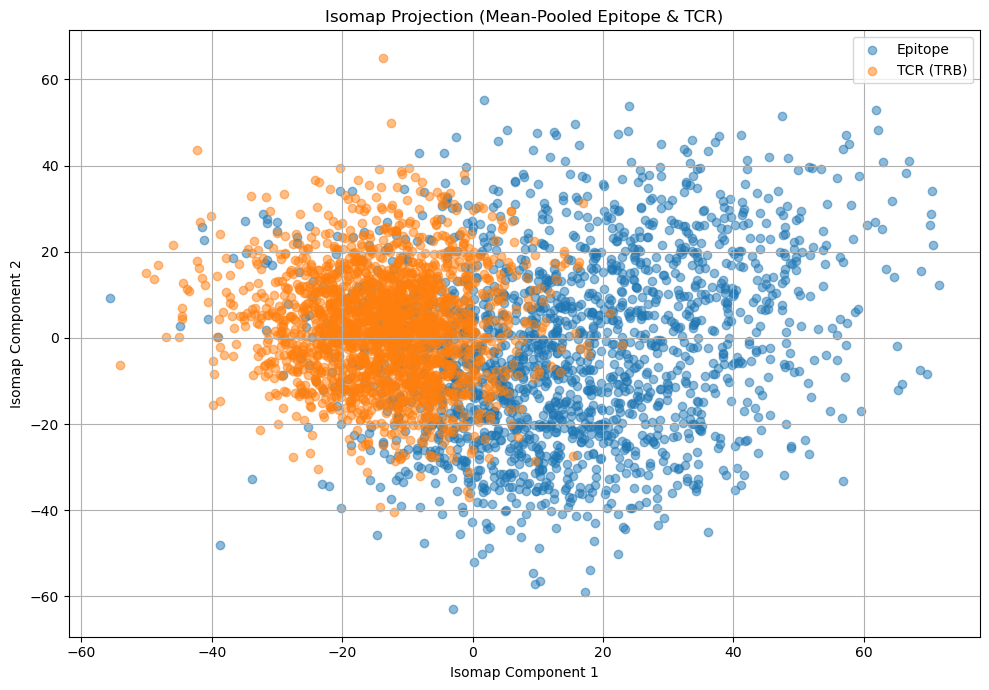

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler

# === Mean Pooling pro Key ===
epi_vectors = [beta_all_epi[k].mean(axis=0) for k in beta_all_epi.files]
trb_keys_subset = list(beta_all_trb.files)[:2000]  # Nur 2000 TRBs für Plot
trb_vectors = [beta_all_trb[k].mean(axis=0) for k in trb_keys_subset]

# Kombinieren
all_vectors = np.vstack(epi_vectors + trb_vectors)

# === Labels für farbliche Trennung ===
labels = np.array([0] * len(epi_vectors) + [1] * len(trb_vectors))

# === Standardisieren
scaler = StandardScaler()
all_vectors_scaled = scaler.fit_transform(all_vectors)

# === Isomap auf 2D reduzieren
isomap = Isomap(n_neighbors=50, n_components=2)
all_vectors_reduced = isomap.fit_transform(all_vectors_scaled)

# === Visualisieren
plt.figure(figsize=(10, 7))
plt.scatter(all_vectors_reduced[labels == 0, 0], all_vectors_reduced[labels == 0, 1], alpha=0.5, label='Epitope')
plt.scatter(all_vectors_reduced[labels == 1, 0], all_vectors_reduced[labels == 1, 1], alpha=0.5, label='TCR (TRB)')
plt.legend()
plt.title("Isomap Projection (Mean-Pooled Epitope & TCR)")
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


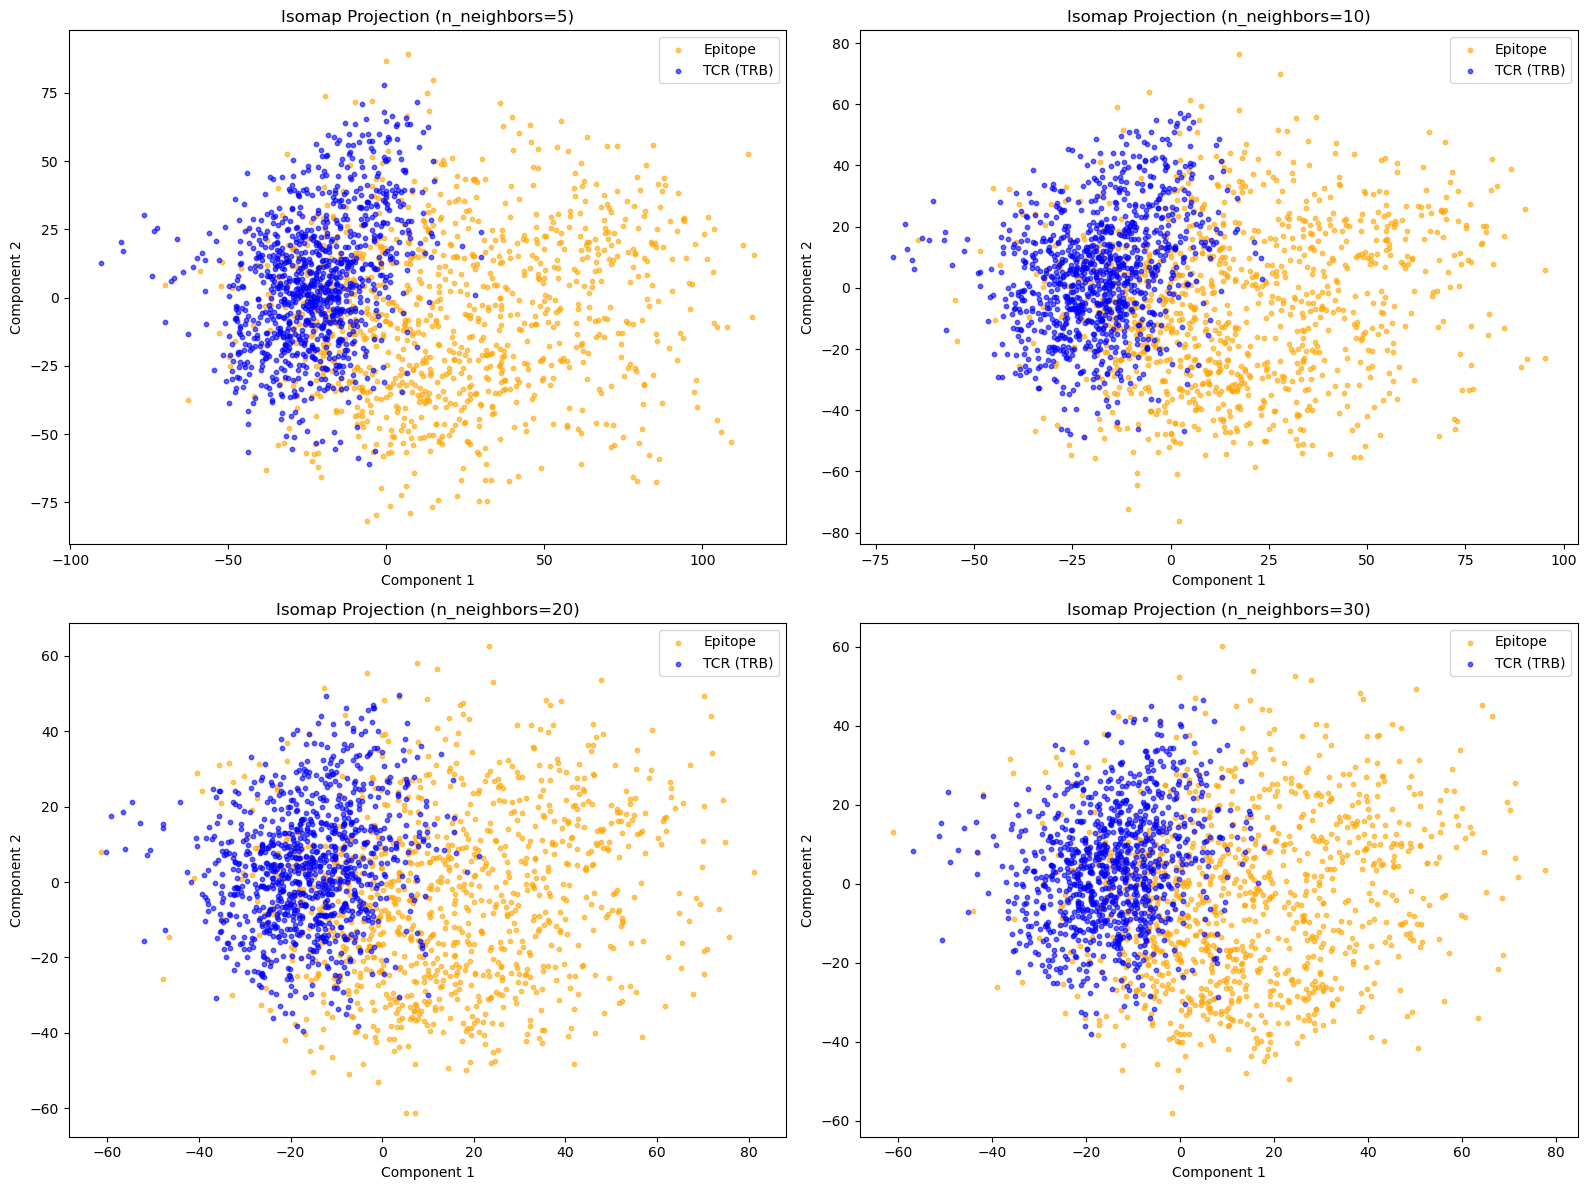

In [22]:
# === Subsample für Visualisierung ===
n_vis = 1000
epi_sampled = random.sample(epi_vectors, n_vis)
trb_sampled = random.sample(trb_vectors, n_vis)

# Richtig kombinieren (nicht all_vectors verwenden!)
all_vectors_sampled = np.vstack(epi_sampled + trb_sampled)
labels_sampled = ['Epitope'] * n_vis + ['TCR'] * n_vis

# === Standardisieren ===
scaler = StandardScaler()
all_vectors_scaled = scaler.fit_transform(all_vectors_sampled)

# === Plot mit verschiedenen Nachbarn ===
neighbors_list = [5, 10, 20, 30]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, n in enumerate(neighbors_list):
    isomap = Isomap(n_neighbors=n, n_components=2)
    projection = isomap.fit_transform(all_vectors_scaled)

    ax = axes[idx]
    ax.scatter(projection[:n_vis, 0], projection[:n_vis, 1],
               c='orange', label='Epitope', alpha=0.6, s=10)
    ax.scatter(projection[n_vis:, 0], projection[n_vis:, 1],
               c='blue', label='TCR (TRB)', alpha=0.6, s=10)
    ax.set_title(f'Isomap Projection (n_neighbors={n})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend()

plt.tight_layout()
plt.show()

Kriterium	          n_neighbors = 10	            n_neighbors = 20
Lokale Struktur	      etwas stärker	                 glatter
Cluster-Trennung	  klar	                         etwas diffuser
Generalisierbarkeit	  Sehr gut	                     auch gut
Risiko von Overfit	  niedrig                    	leicht höher
Rechenzeit	          schneller	    langsamer

***ISOMAP***

sklearn mit GPU-optimierter Berechnung durch CuPy & PyTorch

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # Das erlaubt PyTorch, Speicher besser zu verwalten und Fragmentierung zu vermeiden

In [4]:
import torch
torch.cuda.empty_cache()

In [ ]:
def apply_joint_isomap(epitope_path, tcr_path, epitope_out, tcr_out, n_components=512, n_neighbors=10):
    print("Lade Daten...")
    epi_data = np.load(epitope_path, allow_pickle=True)
    trb_data = np.load(tcr_path, allow_pickle=True)

    epi_keys = list(epi_data.files)
    trb_keys = list(trb_data.files)

    print("Sammle alle Positions-Vektoren...")
    all_pos_vectors = np.concatenate([epi_data[k] for k in epi_keys] + [trb_data[k] for k in trb_keys])
    print(f"Gesamtanzahl Positions-Vektoren: {all_pos_vectors.shape}")

    print("Normalisiere mit StandardScaler...")
    scaler = StandardScaler()
    all_vectors_scaled = scaler.fit_transform(all_pos_vectors)

    print("Reduziere mit Isomap...")
    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    all_vectors_reduced = isomap.fit_transform(all_vectors_scaled)

    print("Teile reduzierte Vektoren wieder in Sequenzen auf...")
    reduced_epi = {}
    reduced_trb = {}
    index = free 

    for key in epi_keys:
        length = epi_data[key].shape[0]
        reduced_epi[key] = all_vectors_reduced[index:index + length]
        index += length

    for key in trb_keys:
        length = trb_data[key].shape[0]
        reduced_trb[key] = all_vectors_reduced[index:index + length]
        index += length

    print("Speichere reduzierte Embeddings...")
    os.makedirs(os.path.dirname(epitope_out), exist_ok=True)
    os.makedirs(os.path.dirname(tcr_out), exist_ok=True)
    np.savez_compressed(epitope_out, **reduced_epi)
    np.savez_compressed(tcr_out, **reduced_trb)

    print("Fertig.")

# Anwendung
apply_joint_isomap(
    epitope_path='../../data/embeddings/beta/allele/Epitope_beta_embeddings.npz',
    tcr_path='../../data/embeddings/beta/allele/TRB_beta_embeddings.npz',
    epitope_out='../../data/embeddings/beta/allele/isomap/Epitope_beta_embeddings_reduced.npz',
    tcr_out='../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz',
    n_components=512,
    n_neighbors=10
)


Lade Daten...
Sammle alle Positions-Vektoren...


**CHECK NACH ISOMAP**

In [ ]:
def verify_isomap_output_full(epitope_path, tcr_path, original_epi_keys, original_trb_keys, n_components=512):
    print("Lade reduzierte Embeddings...")
    epi = np.load(epitope_path, allow_pickle=True)
    trb = np.load(tcr_path, allow_pickle=True)

    epi_keys = list(epi.files)
    trb_keys = list(trb.files)

    print(f"\n Anzahl Epitope Keys: {len(epi_keys)}")
    print(f" Anzahl TCR Keys:     {len(trb_keys)}")

    print(f"\n Beispiel-Keys Epitope: {epi_keys[:3]}")
    print(f" Beispiel-Keys TCR:     {trb_keys[:3]}")

    # Check auf Duplikate
    assert len(epi_keys) == len(set(epi_keys)), "\nDuplikate in Epitope-Keys gefunden!"
    assert len(trb_keys) == len(set(trb_keys)), "\nDuplikate in TCR-Keys gefunden!"
    print("Keine Duplikate in den Keys gefunden.")

    # Shape-Check
    wrong_shapes_epi = [k for k in epi_keys if epi[k].shape != (n_components,)]
    wrong_shapes_trb = [k for k in trb_keys if trb[k].shape != (n_components,)]

    if wrong_shapes_epi or wrong_shapes_trb:
        print("\nEinige Keys haben falsche Shape!")
        if wrong_shapes_epi:
            print(f"   Epitope falsch: {len(wrong_shapes_epi)} → z. B. {wrong_shapes_epi[:3]}")
        if wrong_shapes_trb:
            print(f"   TCR falsch: {len(wrong_shapes_trb)} → z. B. {wrong_shapes_trb[:3]}")
    else:
        print(f" Alle Vektoren haben Shape ({n_components},)")

    # Check auf NaNs
    print("Prüfe auf NaNs...")
    for k in epi_keys:
        assert not np.isnan(epi[k]).any(), f"NaNs in Epitope-Key: {k}"
    for k in trb_keys:
        assert not np.isnan(trb[k]).any(), f"NaNs in TCR-Key: {k}"
    print("Keine NaNs in den Vektoren gefunden.")

    # Check auf fehlende Keys
    print("\nÜberprüfe Vollständigkeit der Keys...")
    missing_epi_keys = set(original_epi_keys) - set(epi_keys)
    missing_trb_keys = set(original_trb_keys) - set(trb_keys)

    if not missing_epi_keys and not missing_trb_keys:
        print("Alle Keys aus den Originaldaten sind in den reduzierten Dateien enthalten.")
    else:
        if missing_epi_keys:
            print(f" Fehlende Epitope Keys ({len(missing_epi_keys)}): {list(missing_epi_keys)[:5]}")
        if missing_trb_keys:
            print(f" Fehlende TCR Keys ({len(missing_trb_keys)}): {list(missing_trb_keys)[:5]}")

    # Optional: Visualisierung
    if n_components == 2:
        print("\n📊 Visualisiere 2D-Projektion...")
        epi_data = np.array([epi[k] for k in epi_keys])
        trb_data = np.array([trb[k] for k in trb_keys])

        plt.figure(figsize=(10, 7))
        plt.scatter(epi_data[:, 0], epi_data[:, 1], c='orange', label='Epitope', alpha=0.6, s=10)
        plt.scatter(trb_data[:, 0], trb_data[:, 1], c='blue', label='TCR (TRB)', alpha=0.6, s=10)
        plt.xlabel('Isomap Component 1')
        plt.ylabel('Isomap Component 2')
        plt.title('2D Isomap Projection – Mean Pooled')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Visualisierung übersprungen (n_components ≠ 2)")

    print("\n Alle Checks abgeschlossen.")


**GETRENNT ISOMAP**

Epitope

In [7]:
def apply_isomap_gpu_preprocessed(input_path, output_path, n_components=512, n_neighbors=10):
    """
    Nutzt GPU für Datenvorbereitung (Normalisierung mit Cupy/PyTorch), aber Isomap läuft auf CPU.
    """
    print(f"📂 Lade Datei: {input_path}")
    data = np.load(input_path, allow_pickle=True)

    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    scaler = StandardScaler()

    all_embeddings = []
    key_list = []

    # 1️⃣ Verarbeitung der Keys auf GPU mit Cupy
    for key in data.files:
        tensor = torch.tensor(data[key], dtype=torch.float32, device="cuda")  # GPU
        all_embeddings.append(tensor)
        key_list.append(key)

    all_embeddings = torch.cat(all_embeddings, dim=0)  # Auf der GPU kombinieren
    print(f"🔢 Gesamtshape vor Isomap: {all_embeddings.shape}")

    # Normalisierung auf der GPU
    all_embeddings = (all_embeddings - all_embeddings.mean()) / all_embeddings.std()

    # Zur CPU zurück, bevor Isomap aufgerufen wird
    all_embeddings_cpu = all_embeddings.cpu().numpy()

    # 2️⃣ CPU-basiertes Isomap Fit & Transform
    reduced_embeddings = isomap.fit_transform(all_embeddings_cpu)

    print(f"✅ Gesamtshape nach Isomap: {reduced_embeddings.shape}")

    # 3️⃣ Zurück auf Keys aufteilen & speichern
    start_idx = 0
    reduced_data = {}

    for i, key in enumerate(key_list):
        num_samples = data[key].shape[0]
        reduced_data[key] = reduced_embeddings[start_idx:start_idx+num_samples]
        start_idx += num_samples

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    np.savez_compressed(output_path, **reduced_data)
    print(f"💾 Reduzierte Embeddings gespeichert unter: {output_path}")

# === Isomap für Epitope-Embeddings ===
apply_isomap_gpu_preprocessed(
    input_path='../../data/embeddings/beta/allele/Epitope_beta_embeddings.npz',
    output_path='../../data/embeddings/beta/allele/isomap/Epitope_beta_embeddings_reduced.npz',
    n_components=512,
    n_neighbors=10
)

''' ***TCR MUSS IN BATCHES VERARBEITET WERDEN***
# === Isomap für TCR-Embeddings ===
apply_isomap_gpu_preprocessed(
    input_path='../../data/embeddings/beta/allele/TRB_beta_embeddings.npz',
    output_path='../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz',
    n_components=512,
    n_neighbors=10
)
'''

📂 Lade Datei: ../../data/embeddings/beta/allele/Epitope_beta_embeddings.npz
🔢 Gesamtshape vor Isomap: torch.Size([19260, 1024])
✅ Gesamtshape nach Isomap: (19260, 512)
💾 Reduzierte Embeddings gespeichert unter: ../../data/embeddings/beta/allele/isomap/Epitope_beta_embeddings_reduced.npz


" ***TCR MUSS IN BATCHES VERARBEITET WERDEN***\n# === Isomap für TCR-Embeddings ===\napply_isomap_gpu_preprocessed(\n    input_path='../../data/embeddings/beta/allele/TRB_beta_embeddings.npz',\n    output_path='../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz',\n    n_components=512,\n    n_neighbors=10\n)\n"

TCRB mit Batches

In [8]:
import numpy as np
import torch
from sklearn.manifold import Isomap
import os

def apply_isomap_gpu_batched(input_path, output_path, n_components=512, n_neighbors=50, batch_size=2000):
    """
    Nutzt GPU für Datenvorbereitung (Normalisierung mit PyTorch), aber verarbeitet TRB in Batches, um Speicherprobleme zu vermeiden.
    """
    print(f"📂 Lade Datei: {input_path}")
    data_npz = np.load(input_path, allow_pickle=True)

    # **Daten in ein veränderbares Dictionary laden & zu float32 konvertieren**
    data = {key: data_npz[key].astype(np.float32) for key in data_npz.files}

    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    key_list = list(data.keys())

    reduced_embeddings = []

    for i in range(0, len(key_list), batch_size):
        batch_keys = key_list[i:i + batch_size]

        # **1️⃣ Lade Daten zuerst in CPU-Speicher**
        batch = [torch.tensor(data[key], dtype=torch.float32) for key in batch_keys]  # Erst auf CPU
        batch = torch.cat(batch, dim=0).to("cuda")  # Erst dann auf GPU schieben
        print(f"🔢 Batch {i//batch_size + 1}: {batch.shape}")

        # **2️⃣ Normalisierung auf GPU**
        batch = (batch - batch.mean()) / batch.std()

        # **3️⃣ Schiebe den Batch zurück auf die CPU für Isomap**
        batch_cpu = batch.cpu().numpy()
        del batch  # GPU-Speicher leeren
        torch.cuda.empty_cache()

        # **4️⃣ CPU-basiertes Isomap Fit & Transform**
        if i == 0:
            reduced_embeddings = isomap.fit_transform(batch_cpu)
        else:
            reduced_embeddings = np.vstack((reduced_embeddings, isomap.transform(batch_cpu)))

        del batch_cpu
        torch.cuda.empty_cache()

    print(f"✅ Gesamtshape nach Isomap: {reduced_embeddings.shape}")

    # **5️⃣ Zurück auf Keys aufteilen & speichern**
    start_idx = 0
    reduced_data = {}

    for key in key_list:
        num_samples = data[key].shape[0]
        reduced_data[key] = reduced_embeddings[start_idx:start_idx+num_samples]
        start_idx += num_samples

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, **reduced_data)
    print(f"💾 Reduzierte Embeddings gespeichert unter: {output_path}")

# **Isomap für TCR-Embeddings (TRB ist groß, daher Batches!)**
apply_isomap_gpu_batched(
    input_path='../../data/embeddings/beta/allele/TRB_beta_embeddings.npz',
    output_path='../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz',
    n_components=512,
    n_neighbors=50,
    batch_size=1000  # Kleinere Batches für besseren Swap-Einsatz
)


📂 Lade Datei: ../../data/embeddings/beta/allele/TRB_beta_embeddings.npz
🔢 Batch 1: torch.Size([14580, 1024])
🔢 Batch 2: torch.Size([14716, 1024])
🔢 Batch 3: torch.Size([14751, 1024])
🔢 Batch 4: torch.Size([14754, 1024])
🔢 Batch 5: torch.Size([14679, 1024])
🔢 Batch 6: torch.Size([14719, 1024])
🔢 Batch 7: torch.Size([14591, 1024])
🔢 Batch 8: torch.Size([14607, 1024])
🔢 Batch 9: torch.Size([14665, 1024])
🔢 Batch 10: torch.Size([14767, 1024])
🔢 Batch 11: torch.Size([14652, 1024])
🔢 Batch 12: torch.Size([14705, 1024])
🔢 Batch 13: torch.Size([14602, 1024])
🔢 Batch 14: torch.Size([14757, 1024])
🔢 Batch 15: torch.Size([14637, 1024])
🔢 Batch 16: torch.Size([14634, 1024])
🔢 Batch 17: torch.Size([14692, 1024])
🔢 Batch 18: torch.Size([14615, 1024])
🔢 Batch 19: torch.Size([14678, 1024])
🔢 Batch 20: torch.Size([14754, 1024])
🔢 Batch 21: torch.Size([14638, 1024])
🔢 Batch 22: torch.Size([14723, 1024])
🔢 Batch 23: torch.Size([14628, 1024])
🔢 Batch 24: torch.Size([14535, 1024])
🔢 Batch 25: torch.Size([1

***ALTER CHECK NACH DIMENSION REDUCTION***

Keys, Shape, Dimension von Embeddings (reduced mit ISOMAP)

In [9]:
# Lade die reduzierten Dateien nach Isomap
beta_all_epi_reduced = np.load('../../data/embeddings/beta/allele/isomap/Epitope_beta_embeddings_reduced.npz')
beta_all_trb_reduced = np.load('../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz')

# Erhalte die Keys als Liste
epi_keys_reduced = list(beta_all_epi_reduced.keys())
trb_keys_reduced = list(beta_all_trb_reduced.keys())

# Drucke die ersten 5 und letzten 5 Keys
print(f"🔢 Anzahl der Keys in Epitope_beta_embeddings_reduced: {len(epi_keys_reduced)}")
print(f"📌 Erste 5 Keys: {epi_keys_reduced[:5]}")
print(f"📌 Letzte 5 Keys: {epi_keys_reduced[-5:]}")


print(f"🔢 Anzahl der Keys in TRB_beta_embeddings_reduced: {len(trb_keys_reduced)}")
print(f"📌 Erste 5 Keys: {trb_keys_reduced[:5]}")
print(f"📌 Letzte 5 Keys: {trb_keys_reduced[-5:]}")

# Prüfe die Form der ersten & letzten 5 Keys für beide Embeddings
print("\n🔹 Shapes der ersten 5 Epitope Keys nach Isomap:")
for key in epi_keys_reduced[:5]:
    print(f"  {key}: {beta_all_epi_reduced[key].shape}")

print("\n🔹 Shapes der letzten 5 Epitope Keys nach Isomap:")
for key in epi_keys_reduced[-5:]:
    print(f"  {key}: {beta_all_epi_reduced[key].shape}")

print("\n🔹 Shapes der ersten 5 TRB Keys nach Isomap:")
for key in trb_keys_reduced[:5]:
    print(f"  {key}: {beta_all_trb_reduced[key].shape}")

print("\n🔹 Shapes der letzten 5 TRB Keys nach Isomap:")
for key in trb_keys_reduced[-5:]:
    print(f"  {key}: {beta_all_trb_reduced[key].shape}")



🔢 Anzahl der Keys in Epitope_beta_embeddings_reduced: 1896
📌 Erste 5 Keys: ['KLVVLGINAV', 'GPGHKARVL', 'FRYMNSQGL', 'NMLSTVLGV', 'DSFKEELDKY']
📌 Letzte 5 Keys: ['ISQWLTNIF', 'SILDAVQRV', 'RLMKHYPGI', 'YLKLTDNVYIK', 'VSALSRAAEK']
🔢 Anzahl der Keys in TRB_beta_embeddings_reduced: 208722
📌 Erste 5 Keys: ['CASSQDNNEQFF', 'CASSVISRVGETQYF', 'CASNPTDGGETQYF', 'CASSGSYAPGADTQYF', 'CASSYPGQNNSPLHF']
📌 Letzte 5 Keys: ['CASSLSQGSYSTDTQYF', 'CASSSSGTTKQPQHF', 'CAGRHLLEAFF', 'CASSVDLSSYNEQFF', 'CASSSGLAGLGEQFF']

🔹 Shapes der ersten 5 Epitope Keys nach Isomap:
  KLVVLGINAV: (10, 512)
  GPGHKARVL: (9, 512)
  FRYMNSQGL: (9, 512)
  NMLSTVLGV: (9, 512)
  DSFKEELDKY: (10, 512)

🔹 Shapes der letzten 5 Epitope Keys nach Isomap:
  ISQWLTNIF: (9, 512)
  SILDAVQRV: (9, 512)
  RLMKHYPGI: (9, 512)
  YLKLTDNVYIK: (11, 512)
  VSALSRAAEK: (10, 512)

🔹 Shapes der ersten 5 TRB Keys nach Isomap:
  CASSQDNNEQFF: (12, 512)
  CASSVISRVGETQYF: (15, 512)
  CASNPTDGGETQYF: (14, 512)
  CASSGSYAPGADTQYF: (16, 512)
  CASSYP

***Padding auf ISOMAP***

TRAIN

In [ ]:
# === Lade den Trainingsdatensatz ===
train_path = '../../data/splitted_datasets/allele/beta/train.tsv'
train_data = pd.read_csv(train_path, sep='\t', low_memory=False)

# === Lade die reduzierten Isomap-Embeddings ===
tcr_embeddings_path = '../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz'
epitope_embeddings_path = '../../data/embeddings/beta/allele/isomap/Epitope_beta_embeddings_reduced.npz'

tcr_data = np.load(tcr_embeddings_path, allow_pickle=True)
epitope_data = np.load(epitope_embeddings_path, allow_pickle=True)

# === Extrahiere die Keys aus dem Trainingsdatensatz ===
tcr_keys = train_data['TRB_CDR3'].dropna().tolist()
epitope_keys = train_data['Epitope'].dropna().tolist()

# === Nur Keys behalten, die in den Embeddings existieren ===
'''
wurde erstetzt mit === Schnelle Version mit set() ===
tcr_keys = [key for key in tcr_keys if key in tcr_data]
epitope_keys = [key for key in epitope_keys if key in epitope_data]
'''
# === Schnelle Version mit set() ===
tcr_keys_set = set(tcr_data.files)  # Mache eine schnelle Hash-Map (Set) für Keys
epitope_keys_set = set(epitope_data.files)

tcr_keys = [key for key in tcr_keys if key in tcr_keys_set]
epitope_keys = [key for key in epitope_keys if key in epitope_keys_set]


# === Dictionaries mit den Trainings-Embeddings erstellen ===
tcr_train_dict = {key: tcr_data[key] for key in tcr_keys}
epitope_train_dict = {key: epitope_data[key] for key in epitope_keys}

# === Maximaler Padding-Wert bestimmen ===
max_tcr_length = max(embedding.shape[0] for embedding in tcr_train_dict.values())
max_epitope_length = max(embedding.shape[0] for embedding in epitope_train_dict.values())

max_length = max(max_tcr_length, max_epitope_length)  # Einheitliche Länge für Transformer

print(f"Max Length: {max_length} (TCR: {max_tcr_length}, Epitope: {max_epitope_length})")

# === Padding-Funktion ===
def pad_embedding(embedding, max_length):
    """
    Padded ein einzelnes Embedding mit Nullen auf max_length.
    """
    padded = np.zeros((max_length, embedding.shape[1]), dtype=embedding.dtype)
    padded[:embedding.shape[0], :] = embedding  # Originalwerte behalten, Rest mit 0 füllen
    return padded

# === Speicherpfade für Trainingsdaten setzen ===
train_tcr_padded_path = '../../data/embeddings/beta/allele/padded_isomap/train_tcr_padded_batches'
train_epitope_padded_path = '../../data/embeddings/beta/allele/padded_isomap/train_epitope_padded_batches'

os.makedirs(train_tcr_padded_path, exist_ok=True)
os.makedirs(train_epitope_padded_path, exist_ok=True)

# === Speicher-Funktion mit Batch-Mechanismus ===
def save_padded_embeddings_in_batches(embeddings_dict, save_dir, batch_size=5000):
    keys = list(embeddings_dict.keys())
    num_batches = (len(keys) + batch_size - 1) // batch_size  # Anzahl der Batches berechnen

    for i in range(num_batches):
        batch_keys = keys[i * batch_size: (i + 1) * batch_size]
        padded_batch = {key: pad_embedding(embeddings_dict[key], max_length) for key in batch_keys}
        
        batch_save_path = os.path.join(save_dir, f"batch_{i}.npz")
        np.savez_compressed(batch_save_path, **padded_batch)
        print(f"Saved batch {i + 1}/{num_batches} to {batch_save_path}")

    print("All batches saved successfully!")

# === Train-Embeddings padden und speichern ===
save_padded_embeddings_in_batches(tcr_train_dict, train_tcr_padded_path, batch_size=5000)
save_padded_embeddings_in_batches(epitope_train_dict, train_epitope_padded_path, batch_size=5000)

# === Finale HDF5-Dateien aus gepaddeten Batches erstellen ===
def combine_selected_batches_to_hdf5(batch_files, output_path):
    """
    Kombiniert eine spezifische Liste von Batch-Dateien zu einer einzigen HDF5-Datei.
    """
    if not batch_files:
        print(f"Keine Batch-Dateien in der Liste gefunden.")
        return

    with h5py.File(output_path, 'w') as hdf5_file:
        for i, batch_file in enumerate(batch_files):
            batch = np.load(batch_file, allow_pickle=True)

            for key in batch.files:
                if key not in hdf5_file:
                    hdf5_file.create_dataset(key, data=batch[key], compression="gzip")
                else:
                    print(f"Duplikat-Key übersprungen: {key}")

            print(f"Batch {i+1}/{len(batch_files)} verarbeitet: {batch_file}")

    print(f"Finale gepaddete Embeddings gespeichert unter: {output_path}")

# === TCR & Epitope Batches für Train zusammenführen ===
train_tcr_batches = [f"../../data/embeddings/beta/allele/padded_isomap/train_tcr_padded_batches/batch_{i}.npz" for i in range(34)]
train_epitope_batches = ["../../data/embeddings/beta/allele/padded_isomap/train_epitope_padded_batches/batch_0.npz"]

combine_selected_batches_to_hdf5(
    batch_files=train_tcr_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_train_tcr_embeddings_final.h5'
)

combine_selected_batches_to_hdf5(
    batch_files=train_epitope_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_train_epitope_embeddings_final.h5'
)

# === Überprüfe die HDF5-Dateien ===
def check_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hdf5_file:
        keys = list(hdf5_file.keys())
        print(f"HDF5-Datei geladen: {file_path}")
        print(f"Anzahl Keys: {len(keys)}")
        print(f"Beispiel-Keys: {keys[:5]}")

# Überprüfe Train-TCR
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_train_tcr_embeddings_final.h5')

# Überprüfe Train-Epitope
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_train_epitope_embeddings_final.h5')


In [ ]:
# === Finale HDF5-Dateien aus gepaddeten Batches erstellen ===
def combine_selected_batches_to_hdf5(batch_files, output_path):
    """
    Kombiniert eine spezifische Liste von Batch-Dateien zu einer einzigen HDF5-Datei.
    """
    if not batch_files:
        print(f"❌ Keine Batch-Dateien in der Liste gefunden.")
        return

    with h5py.File(output_path, 'w') as hdf5_file:
        for i, batch_file in enumerate(batch_files):
            batch = np.load(batch_file, allow_pickle=True)

            for key in batch.files:
                if key not in hdf5_file:
                    hdf5_file.create_dataset(key, data=batch[key], compression="gzip")
                else:
                    print(f"⚠️ Duplikat-Key übersprungen: {key}")

            print(f"🔄 Batch {i+1}/{len(batch_files)} verarbeitet: {batch_file}")

    print(f"✅ Finale gepaddete Embeddings gespeichert unter: {output_path}")

# === TCR & Epitope Batches für Train zusammenführen ===
train_tcr_batches = [f"../../data/embeddings/beta/allele/padded_isomap/train_tcr_padded_batches/batch_{i}.npz" for i in range(34)]
train_epitope_batches = ["../../data/embeddings/beta/allele/padded_isomap/train_epitope_padded_batches/batch_0.npz"]

combine_selected_batches_to_hdf5(
    batch_files=train_tcr_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_train_tcr_embeddings_final.h5'
)

combine_selected_batches_to_hdf5(
    batch_files=train_epitope_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_train_epitope_embeddings_final.h5'
)

# === Überprüfe die HDF5-Dateien ===
def check_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hdf5_file:
        keys = list(hdf5_file.keys())
        print(f"✅ HDF5-Datei geladen: {file_path}")
        print(f"Anzahl Keys: {len(keys)}")
        print(f"Beispiel-Keys: {keys[:5]}")

# Überprüfe Train-TCR
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_train_tcr_embeddings_final.h5')

# Überprüfe Train-Epitope
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_train_epitope_embeddings_final.h5')

VALIDATION

In [ ]:
max_length = 43

In [ ]:
# === Speicher-Funktion mit Batch-Mechanismus ===
def save_padded_embeddings_in_batches(embeddings_dict, save_dir, batch_size=5000):
    keys = list(embeddings_dict.keys())
    num_batches = (len(keys) + batch_size - 1) // batch_size  # Anzahl der Batches berechnen

    for i in range(num_batches):
        batch_keys = keys[i * batch_size: (i + 1) * batch_size]
        padded_batch = {key: pad_embedding(embeddings_dict[key], max_length) for key in batch_keys}
        
        batch_save_path = os.path.join(save_dir, f"batch_{i}.npz")
        np.savez_compressed(batch_save_path, **padded_batch)
        print(f"✅ Saved batch {i + 1}/{num_batches} to {batch_save_path}")

    print("✅ All batches saved successfully!")

# === Finale HDF5-Dateien aus gepaddeten Batches erstellen ===
def combine_selected_batches_to_hdf5(batch_files, output_path):
    """
    Kombiniert eine spezifische Liste von Batch-Dateien zu einer einzigen HDF5-Datei.
    """
    if not batch_files:
        print(f"❌ Keine Batch-Dateien in der Liste gefunden.")
        return

    with h5py.File(output_path, 'w') as hdf5_file:
        for i, batch_file in enumerate(batch_files):
            batch = np.load(batch_file, allow_pickle=True)

            for key in batch.files:
                if key not in hdf5_file:
                    hdf5_file.create_dataset(key, data=batch[key], compression="gzip")
                else:
                    print(f"⚠️ Duplikat-Key übersprungen: {key}")

            print(f"🔄 Batch {i+1}/{len(batch_files)} verarbeitet: {batch_file}")

    print(f"✅ Finale gepaddete Embeddings gespeichert unter: {output_path}")

# === Überprüfe die HDF5-Dateien ===
def check_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hdf5_file:
        keys = list(hdf5_file.keys())
        print(f"✅ HDF5-Datei geladen: {file_path}")
        print(f"Anzahl Keys: {len(keys)}")
        print(f"Beispiel-Keys: {keys[:5]}")

# === Padding-Funktion ===
def pad_embedding(embedding, max_length):
    """
    Padded ein einzelnes Embedding mit Nullen auf max_length.
    """
    padded = np.zeros((max_length, embedding.shape[1]), dtype=embedding.dtype)
    padded[:embedding.shape[0], :] = embedding  # Originalwerte behalten, Rest mit 0 füllen
    return padded

In [ ]:
# === Lade den Validierungsdatensatz ===
validation_path = '../../data/splitted_datasets/allele/beta/validation.tsv'
valid_data = pd.read_csv(validation_path, sep='\t', low_memory=False)

# === Lade die Keys aus dem Validierungsdatensatz ===
valid_tcr_keys = valid_data['TRB_CDR3'].dropna().tolist()
valid_epitope_keys = valid_data['Epitope'].dropna().tolist()

# === Lade die reduzierten Isomap-Embeddings ===
tcr_embeddings_path = '../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz'
epitope_embeddings_path = '../../data/embeddings/beta/allele/isomap/Epitope_beta_embeddings_reduced.npz'

tcr_data = np.load(tcr_embeddings_path, allow_pickle=True)
epitope_data = np.load(epitope_embeddings_path, allow_pickle=True)

# === Schnelle Version mit set() ===
tcr_keys_set = set(tcr_data.files)  # Mache eine schnelle Hash-Map (Set) für Keys
epitope_keys_set = set(epitope_data.files)

valid_tcr_keys = [key for key in valid_tcr_keys if key in tcr_keys_set]
valid_epitope_keys = [key for key in valid_epitope_keys if key in epitope_keys_set]


In [ ]:
# === Dictionaries für Validierungs-Embeddings erstellen ===
valid_tcr_embeddings_dict = {key: tcr_data[key] for key in valid_tcr_keys}
valid_epitope_embeddings_dict = {key: epitope_data[key] for key in valid_epitope_keys}

In [ ]:
# === Speicherpfade für Validierungsdaten setzen ===
valid_tcr_padded_path = '../../data/embeddings/beta/allele/padded_isomap/valid_tcr_padded_batches'
valid_epitope_padded_path = '../../data/embeddings/beta/allele/padded_isomap/valid_epitope_padded_batches'

os.makedirs(valid_tcr_padded_path, exist_ok=True)
os.makedirs(valid_epitope_padded_path, exist_ok=True)

In [ ]:
# === Validierungsdaten padden und speichern ===
save_padded_embeddings_in_batches(valid_tcr_embeddings_dict, valid_tcr_padded_path, batch_size=5000)
save_padded_embeddings_in_batches(valid_epitope_embeddings_dict, valid_epitope_padded_path, batch_size=5000)

In [ ]:
# === Validierungs-Batches zusammenführen ===
valid_tcr_batches = [f"../../data/embeddings/beta/allele/padded_isomap/valid_tcr_padded_batches/batch_{i}.npz" for i in range(17)]
valid_epitope_batches = ["../../data/embeddings/beta/allele/padded_isomap/valid_epitope_padded_batches/batch_0.npz"]

combine_selected_batches_to_hdf5(
    batch_files=valid_tcr_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_valid_tcr_embeddings_final.h5'
)

combine_selected_batches_to_hdf5(
    batch_files=valid_epitope_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_valid_epitope_embeddings_final.h5'
)

In [ ]:
# Überprüfe Valid-TCR
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_valid_tcr_embeddings_final.h5')

# Überprüfe Valid-Epitope
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_valid_epitope_embeddings_final.h5')

TEST

In [ ]:
# === Lade den Testdatensatz ===
test_path = '../../data/splitted_datasets/allele/beta/test.tsv'
test_data = pd.read_csv(test_path, sep='\t', low_memory=False)

# === Lade die Keys aus dem Testdatensatz ===
test_tcr_keys = test_data['TRB_CDR3'].dropna().tolist()
test_epitope_keys = test_data['Epitope'].dropna().tolist()

# === Lade die reduzierten Isomap-Embeddings ===
tcr_embeddings_path = '../../data/embeddings/beta/allele/isomap/TRB_beta_embeddings_reduced.npz'
epitope_embeddings_path = '../../data/embeddings/beta/allele/isomap/Epitope_beta_embeddings_reduced.npz'

tcr_data = np.load(tcr_embeddings_path, allow_pickle=True)
epitope_data = np.load(epitope_embeddings_path, allow_pickle=True)

# === Schnelle Version mit set() ===
tcr_keys_set = set(tcr_data.files)  # Mache eine schnelle Hash-Map (Set) für Keys
epitope_keys_set = set(epitope_data.files)

test_tcr_keys = [key for key in test_tcr_keys if key in tcr_keys_set]
test_epitope_keys = [key for key in test_epitope_keys if key in epitope_keys_set]

# === Dictionaries für Test-Embeddings erstellen ===
test_tcr_embeddings_dict = {key: tcr_data[key] for key in test_tcr_keys}
test_epitope_embeddings_dict = {key: epitope_data[key] for key in test_epitope_keys}

# === Speicherpfade für Testdaten setzen ===
test_tcr_padded_path = '../../data/embeddings/beta/allele/padded_isomap/test_tcr_padded_batches'
test_epitope_padded_path = '../../data/embeddings/beta/allele/padded_isomap/test_epitope_padded_batches'

os.makedirs(test_tcr_padded_path, exist_ok=True)
os.makedirs(test_epitope_padded_path, exist_ok=True)

# === Testdaten padden und speichern ===
save_padded_embeddings_in_batches(test_tcr_embeddings_dict, test_tcr_padded_path, batch_size=5000)
save_padded_embeddings_in_batches(test_epitope_embeddings_dict, test_epitope_padded_path, batch_size=5000)

In [ ]:
# === Test-Batches zusammenführen ===
test_tcr_batches = [f"../../data/embeddings/beta/allele/padded_isomap/test_tcr_padded_batches/batch_{i}.npz" for i in range(9)]
test_epitope_batches = ["../../data/embeddings/beta/allele/padded_isomap/test_epitope_padded_batches/batch_0.npz"]

combine_selected_batches_to_hdf5(
    batch_files=test_tcr_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_test_tcr_embeddings_final.h5'
)

combine_selected_batches_to_hdf5(
    batch_files=test_epitope_batches,
    output_path='../../data/embeddings/beta/allele/padded_isomap/padded_test_epitope_embeddings_final.h5'
)

# === Überprüfe Test-HDF5-Dateien ===
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_test_tcr_embeddings_final.h5')
check_hdf5_file('../../data/embeddings/beta/allele/padded_isomap/padded_test_epitope_embeddings_final.h5')

***CHECK NACH PADDING UND ALLEM***

***PCA***

In [ ]:
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

def apply_joint_pca_and_save(
    epitope_input_path,
    tcr_input_path,
    epitope_output_path,
    tcr_output_path,
    n_components=512,
    batch_size=50000
):
    print("Lade Epitope- und TCR-Daten...")
    epi_data = np.load(epitope_input_path, allow_pickle=True, mmap_mode="r")
    tcr_data = np.load(tcr_input_path, allow_pickle=True, mmap_mode="r")

    epi_keys = list(epi_data.files)
    tcr_keys = list(tcr_data.files)

    print("Initialisiere Scaler und PCA...")
    scaler = StandardScaler()
    pca = IncrementalPCA(n_components=n_components)

    # === GLOBALER FIT SCALER ===
    print("[1/4] Globaler Scaler-Fit über Epitope & TCR...")
    for dataset in [epi_data, tcr_data]:
        for key in dataset.files:
            for i in range(0, dataset[key].shape[0], batch_size):
                batch = dataset[key][i:i+batch_size]
                scaler.partial_fit(batch)
    print("Scaler-Fit abgeschlossen.\n")

    # === PCA-FIT über beide Datensätze ===
    print("[2/4] Starte PCA-Fit über Epitope & TCR...")
    buffer = []
    for dataset in [epi_data, tcr_data]:
        for key in dataset.files:
            for i in range(0, dataset[key].shape[0], batch_size):
                batch = scaler.transform(dataset[key][i:i+batch_size])
                buffer.append(batch)

                total_buffered = sum(b.shape[0] for b in buffer)
                if total_buffered >= n_components:
                    combined = np.vstack(buffer)
                    pca.partial_fit(combined)
                    buffer = []

    if buffer:
        combined = np.vstack(buffer)
        if combined.shape[0] < n_components:
            missing = n_components - combined.shape[0]
            filler = combined[np.random.choice(combined.shape[0], size=missing, replace=True)]
            combined = np.vstack([combined, filler])
            print(f" Letzter Mini-Batch wurde auf {combined.shape[0]} aufgefüllt für PCA-Fit.")
        pca.partial_fit(combined)

    print("PCA-Fit abgeschlossen.\n")

    # === TRANSFORMATION pro Datensatz ===
    def transform_and_save(data, key_list, out_path, label):
        print(f"[3/4] Transformiere {label}-Daten und speichere...")
        reduced_data = {}
        for key in key_list:
            chunks = []
            for i in range(0, data[key].shape[0], batch_size):
                batch = scaler.transform(data[key][i:i+batch_size])
                reduced = pca.transform(batch)
                chunks.append(reduced)
            reduced_data[key] = np.vstack(chunks)
            print(f"  {label}-PCA: {key} → {reduced_data[key].shape}")
        np.savez_compressed(out_path, **reduced_data)
        print(f"{label}-Embeddings gespeichert unter: {out_path}\n")

    transform_and_save(epi_data, epi_keys, epitope_output_path, label="Epitope")
    transform_and_save(tcr_data, tcr_keys, tcr_output_path, label="TCR")

    print("[4/4] Alle Embeddings erfolgreich reduziert & gespeichert.")

# === Aufruf mit Pfaden ===
apply_joint_pca_and_save(
    epitope_input_path='../../data/embeddings/beta/allele/Epitope_beta_embeddings.npz',
    tcr_input_path='../../data/embeddings/beta/allele/TRB_beta_embeddings.npz',
    epitope_output_path='../../data/embeddings/beta/allele/pca/Epitope_beta_embeddings_reduced.npz',
    tcr_output_path='../../data/embeddings/beta/allele/pca/TRB_beta_embeddings_reduced.npz',
    n_components=512,
    batch_size=50000
)

**Kontrolle PCA:**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# === Dateipfade (bei Bedarf anpassen) ===
base_path = "../../data/embeddings/beta/allele"
original_epitope_path = os.path.join(base_path, "Epitope_beta_embeddings.npz")
original_tcr_path = os.path.join(base_path, "TRB_beta_embeddings.npz")

reduced_epitope_path = os.path.join(base_path, "pca", "Epitope_beta_embeddings_reduced.npz")
reduced_tcr_path = os.path.join(base_path, "pca", "TRB_beta_embeddings_reduced.npz")

# === Lade die Daten ===
print("Lade originale & reduzierte Embeddings...")
epi_orig = np.load(original_epitope_path, allow_pickle=True)
tcr_orig = np.load(original_tcr_path, allow_pickle=True)
epi_red = np.load(reduced_epitope_path, allow_pickle=True)
tcr_red = np.load(reduced_tcr_path, allow_pickle=True)

## === Wähle eine kleine Stichprobe aus beiden Datensätzen ===
def sample_and_concatenate(npz_data, n_samples=1000):
    embeddings = []
    for key in npz_data.files:
        emb = npz_data[key]
        if emb.shape[0] > n_samples:
            idx = np.random.choice(emb.shape[0], n_samples, replace=False)
            emb = emb[idx]
        embeddings.append(emb)
    return np.vstack(embeddings)

epi_sample_orig = sample_and_concatenate(epi_orig)
tcr_sample_orig = sample_and_concatenate(tcr_orig)
epi_sample_red = sample_and_concatenate(epi_red)
tcr_sample_red = sample_and_concatenate(tcr_red)
'''
# === Kombiniere und prüfe Dimensionsreduktion mit TSNE (Visualisierung) ===
combined_orig = np.vstack([epi_sample_orig, tcr_sample_orig])
combined_red = np.vstack([epi_sample_red, tcr_sample_red])

tsne_orig = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_red = TSNE(n_components=2, perplexity=30, learning_rate=200)

proj_orig = tsne_orig.fit_transform(combined_orig)
proj_red = tsne_red.fit_transform(combined_red)

# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Original Embeddings (TSNE)")
plt.scatter(proj_orig[:len(epi_sample_orig), 0], proj_orig[:len(epi_sample_orig), 1], label="Epitope", alpha=0.5)
plt.scatter(proj_orig[len(epi_sample_orig):, 0], proj_orig[len(epi_sample_orig):, 1], label="TCR", alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Reduced Embeddings (PCA + TSNE)")
plt.scatter(proj_red[:len(epi_sample_red), 0], proj_red[:len(epi_sample_red), 1], label="Epitope", alpha=0.5)
plt.scatter(proj_red[len(epi_sample_red):, 0], proj_red[len(epi_sample_red):, 1], label="TCR", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
'''

Lade originale & reduzierte Embeddings...


KeyboardInterrupt: 

In [ ]:
# === Check: Key-Konsistenz ===
assert set(epi_orig.files) == set(epi_red.files), "Mismatch in Epitope keys"
assert set(tcr_orig.files) == set(tcr_red.files), "Mismatch in TCR keys"
print("Alle Keys stimmen überein!")

# === Beispiel-Visualisierung mit t-SNE für jeweils 1 Datensatz aus Epitope und TCR ===
def visualize_tsne(original_data, reduced_data, label):
    key = list(original_data.keys())[0]
    X_orig = original_data[key]
    X_red = reduced_data[key]

    print(f"\n Visualisierung für {label} - Key: {key}")
    print(f"  Original shape: {X_orig.shape}")
    print(f"  Reduced shape: {X_red.shape}")

    n_samples = min(300, X_orig.shape[0])
    idx = np.random.choice(X_orig.shape[0], n_samples, replace=False)

    X_tsne_orig = TSNE(n_components=2, random_state=42).fit_transform(X_orig[idx])
    X_tsne_red = TSNE(n_components=2, random_state=42).fit_transform(X_red[idx])

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(X_tsne_orig[:, 0], X_tsne_orig[:, 1], c='blue', alpha=0.6)
    ax[0].set_title(f"{label} Original ({X_orig.shape[1]}D) → t-SNE")
    ax[1].scatter(X_tsne_red[:, 0], X_tsne_red[:, 1], c='green', alpha=0.6)
    ax[1].set_title(f"{label} PCA-Reduced ({X_red.shape[1]}D) → t-SNE")
    plt.suptitle(f"{label} – t-SNE Vergleich Original vs PCA-Reduziert")
    plt.tight_layout()
    plt.show()

visualize_tsne(epi_orig, epi_red, "Epitope")
visualize_tsne(tcr_orig, tcr_red, "TCR")